In [1]:
import tensorflow as tf
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers

In [5]:
train_dg = ImageDataGenerator(rescale=1/255.,
                             rotation_range=40,
                            width_shift_range=0.2,
                            height_shift_range=0.2,
                            shear_range=0.2,
                            zoom_range=0.2,
                            horizontal_flip=True,
                            fill_mode='nearest')
test_dg = ImageDataGenerator(rescale=1/255.)

In [6]:
train_generator = train_dg.flow_from_directory('train/', target_size=(224,224), batch_size=16)
valid_generator = test_dg.flow_from_directory('test/', target_size=(224,224), batch_size=16)

Found 4500 images belonging to 12 classes.
Found 1500 images belonging to 12 classes.


In [7]:
base_model = tf.keras.applications.Xception(input_shape = (224,224,3), 
                                               include_top = False,
                                               weights = "imagenet")

In [8]:
base_model.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 111, 111, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                          

In [9]:
base_model.trainable = True

In [10]:
base_model.output

<KerasTensor: shape=(None, 7, 7, 2048) dtype=float32 (created by layer 'block14_sepconv2_act')>

In [11]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)

In [12]:
dropout_layer = tf.keras.layers.Dropout(0.5)(global_average_layer)

In [13]:
x = tf.keras.layers.Dense(1024, activation='relu')(dropout_layer)

In [14]:
prediction_layer = tf.keras.layers.Dense(units = 12, activation = "softmax", kernel_regularizer=regularizers.l2(0.01))(x)

In [15]:
model = tf.keras.models.Model(inputs = base_model.input, outputs = prediction_layer)

In [16]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 111, 111, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                             

In [17]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.000025),
              loss="categorical_crossentropy", metrics = ["accuracy"])

In [18]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='ModeloXception.h5',     
    monitor='val_loss',            
    save_best_only=True,             
    save_weights_only=False,          
    mode='min',                      
    verbose=1                         
)

In [25]:
model.fit(train_generator, epochs=20, validation_data=valid_generator, callbacks=[checkpoint_callback])

Epoch 1/20
282/282 [==============================] - ETA: 0s - loss: 2.5977 - accuracy: 0.1918
Epoch 1: val_loss improved from inf to 2.23080, saving model to ModeloXception.h5
282/282 [==============================] - 105s 313ms/step - loss: 2.5977 - accuracy: 0.1918 - val_loss: 2.2308 - val_accuracy: 0.3820
Epoch 2/20
282/282 [==============================] - ETA: 0s - loss: 1.9998 - accuracy: 0.4464
Epoch 2: val_loss improved from 2.23080 to 1.59149, saving model to ModeloXception.h5
282/282 [==============================] - 77s 272ms/step - loss: 1.9998 - accuracy: 0.4464 - val_loss: 1.5915 - val_accuracy: 0.5593
Epoch 3/20
282/282 [==============================] - ETA: 0s - loss: 1.5485 - accuracy: 0.5716
Epoch 3: val_loss improved from 1.59149 to 1.37603, saving model to ModeloXception.h5
282/282 [==============================] - 63s 223ms/step - loss: 1.5485 - accuracy: 0.5716 - val_loss: 1.3760 - val_accuracy: 0.6287
Epoch 4/20
282/282 [==============================] - E

In [13]:
modelo = tf.keras.models.load_model('ModeloXception.h5')

result = modelo.evaluate(valid_generator)
print(result)

94/94 [==============================] - 11s 40ms/step - loss: 1.0766 - accuracy: 0.7273
[1.076576590538025, 0.7273333072662354]


In [14]:
images_list = []
labels_list = []

# Iterar sobre o gerador e armazenar as imagens e os rótulos
for i in range(len(valid_generator)):
    # Obter lote de imagens e rótulos
    images, labels = valid_generator[i]
    # Verificar se os lotes são arrays NumPy e têm as formas esperadas
    if isinstance(images, np.ndarray) and images.ndim == 4 and isinstance(labels, np.ndarray):
        images_list.append(images)
        labels_list.append(labels)
    else:
        print(f"Lote {i} não é válido. Ignorando.")

# Concatenar todas as imagens e rótulos em arrays únicos
if images_list and labels_list:
    images_array = np.concatenate(images_list, axis=0)
    labels_array = np.concatenate(labels_list, axis=0)
    print(f"Shape do array de imagens: {images_array.shape}")
    print(f"Shape do array de rótulos: {labels_array.shape}")
else:
    print("Nenhuma imagem ou rótulo foi processado corretamente.")

Shape do array de imagens: (1500, 224, 224, 3)
Shape do array de rótulos: (1500, 12)


In [15]:
pred = modelo.predict(images_array)
pred = np.argmax(pred, axis=1)

labels_array = np.argmax(labels_array, axis=1)

47/47 [==============================] - 4s 75ms/step


In [16]:
cm = tf.math.confusion_matrix(labels_array, pred)

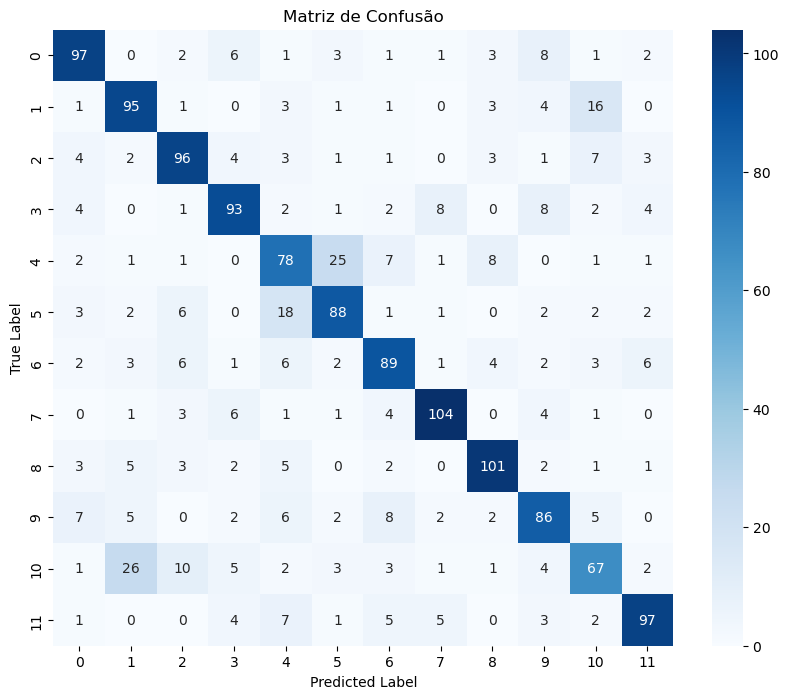

In [17]:
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Matriz de Confusão')
plt.show()

In [47]:
type(valid_generator)

keras.preprocessing.image.DirectoryIterator

In [49]:
imgs, classes = valid_generator.__getitem__(0)

In [51]:
classes

array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]], dtype=float32)

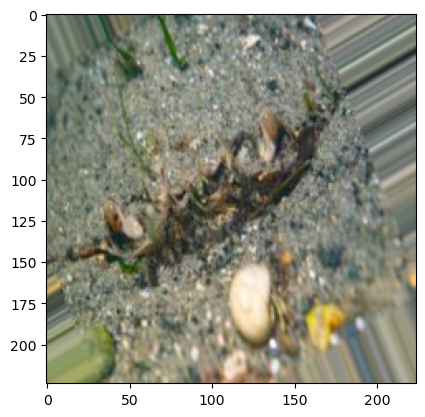

In [59]:
plt.imshow(imgs[0])

In [57]:
model.predict(tf.expand_dims(imgs[8], axis=0))

1/1 [==============================] - 0s 23ms/step


array([[1.7923959e-02, 1.0084262e-01, 5.2362885e-02, 1.1751564e-01,
        5.9918221e-03, 6.4050424e-01, 3.1025748e-04, 5.6090014e-04,
        5.1610434e-04, 6.3471556e-02]], dtype=float32)